In [12]:
import numpy as np
import torch

from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook, trange

import itertools

In [13]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

In [14]:
from pathlib import Path

In [28]:
DEVICE = torch.device('cuda:2')

In [16]:
from src.utils.ensemble import optimize_val_correlation
from src.config.config import combine_cfgs, get_cfg_defaults
from src.data.datamodule import MyDataModule

In [17]:
# prepare validation data
cfg = combine_cfgs('../src/config/experiments/algonauts2021_i3d_flow.yml')
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

val_indices = dm.val_dataset.indices

cache_path = Path('/data_smr/huze/.cache/val_fmris.pt')

if cache_path.exists():
    val_fmris = torch.load(cache_path)
else:
    val_fmris = [dm.dataset_train_val.__getitem__(i)[1] for i in tqdm(val_indices)]
    val_fmris = np.stack(val_fmris, 0)
    val_fmris = torch.tensor(val_fmris)
    torch.save(val_fmris, cache_path)

In [18]:
roi_sch_dict = {
    'WB': ['WB'],
    'ROI': ['V1', 'V2', 'V3', 'V4', 'EBA', 'LOC', 'PPA', 'FFA', 'STS', 'REST'],
    'LC': ['LC1', 'LC2', 'LC3', 'LC4', 'LC5'],
    'MC': ['MC1', 'MC2', 'LC2', 'LC3', 'LC4', 'LC5'],
    'SMC': ['SMC1', 'SMC2', 'MC2', 'LC2', 'LC3', 'LC4', 'LC5'],
    'SC': ['SMC1', 'SMC2', 'SC3', 'SC4', 'LC2', 'LC3', 'LC4', 'LC5'],
}

In [19]:
del roi_sch_dict['WB'] # WB is already in level 0

# combine ROI-kROI model

In [82]:
# read ensemble outputs from notebook 1. (cross-notebook-ref)

In [83]:
results_dir = Path('/data/huze/ray_results/algonauts2021')
tmp_dir = results_dir.joinpath('ensemble_outputs')

In [100]:
ensemble_configs = [('single_layer&i3d_rgb+i3d_flow', 'H1'),
 ('single_layer&i3d_rgb+i3d_flow', 'H2'),
 ('single_layer&i3d_rgb+i3d_flow', 'H3'),
 ('single_layer+multi_layer&i3d_rgb', 'H3'),
 ('single_layer+multi_layer&i3d_flow', 'H3'),
 ('single_layer+multi_layer&i3d_rgb+i3d_flow', 'H3'),
 ('single_layer&i3d_rgb', 'H3'),
 ('single_layer&i3d_flow', 'H3'),
 ('single_layer&i3d_rgb+i3d_flow', 'H3'),
 ('multi_layer&i3d_rgb', 'H3'),
 ('multi_layer&i3d_flow', 'H3'),
 ('multi_layer&i3d_rgb+i3d_flow', 'H3')]
print(len(ensemble_configs))
ensemble_configs = set(ensemble_configs)
print(len(ensemble_configs))

12
11


In [101]:
from src.utils.metrics import vectorized_correlation

In [102]:
import pandas as pd

In [103]:
sch_rois1_name = 'ROI'
sch_rois1 = roi_sch_dict[sch_rois1_name]
sch_rois2_names = list(roi_sch_dict.keys())
sch_rois2_names.remove('ROI') # ROIxSMC ROIxLC ...

skip_existing = True # will also skip plotting

cross_roi_res_dicts = []
for model_sch, he_sch in ensemble_configs:
    for sch_rois2_name in tqdm(sch_rois2_names, desc=f'he_sch={he_sch} \t model_sch={model_sch}'):
        
        save_paths = [tmp_dir.joinpath(Path(
            f'he_sch={he_sch},model_sch={model_sch},roi_sch={sch_rois1_name}x{sch_rois2_name},cross_roi_sch={cross_roi_sch}-prediction.pt'))
                     for cross_roi_sch in ['croi_swap', 'croi_ensemble', 'voxel_swap']]
        if skip_existing and np.all([p.exists() for p in save_paths]): continue
        
        sch_rois2 = roi_sch_dict[sch_rois2_name]
        path1 = Path(os.path.join(tmp_dir,
                             f'he_sch={he_sch},model_sch={model_sch},roi_sch={sch_rois1_name}'
                             f'-prediction.pt'))
        path2 = Path(os.path.join(tmp_dir,
                             f'he_sch={he_sch},model_sch={model_sch},roi_sch={sch_rois2_name}'
                             f'-prediction.pt'))
        if not (path1.exists() and path2.exists()): continue
        prediction1 = torch.load(path1)
        prediction2 = torch.load(path2)
        

        new_prediction_croi_swap = torch.zeros(prediction1.shape)
        new_prediction_croi_ensemble = torch.zeros(prediction1.shape)
        new_prediction_voxel_swap = torch.zeros(prediction1.shape)

        for roi1_name, roi2_name in itertools.product(sch_rois1, sch_rois2):
            voxel_indices1 = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi1_name}.pt'))
            voxel_indices2 = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi2_name}.pt'))
            intersect_vi = torch.tensor(np.intersect1d(voxel_indices1, voxel_indices2))

            if len(intersect_vi) > 0:
                voxel_scores = np.asarray([
                    vectorized_correlation(prediction1[val_indices][..., intersect_vi],
                                           val_fmris[..., intersect_vi]).numpy(),
                    vectorized_correlation(prediction2[val_indices][..., intersect_vi],
                                           val_fmris[..., intersect_vi]).numpy(),
                ])
                croi_scores = voxel_scores.mean(1)
                roi_sch1_score = croi_scores[0]
                roi_sch2_score = croi_scores[1]

                predictions = torch.stack([prediction1[..., intersect_vi],
                                           prediction2[..., intersect_vi]], -1)

                # swap to better score model (cROI)
                croi_swap_prediction = predictions[..., croi_scores.argmax()]
                croi_swap_score = np.max(croi_scores)
                new_prediction_croi_swap[..., intersect_vi] = croi_swap_prediction

                # swap to better score model (voxel)
                vsargmax = voxel_scores.argmax(0)
                voxel_swap_prediction = torch.stack([predictions[:, i, idx] for i, idx in enumerate(vsargmax)], -1)
                voxel_swap_num_better_1 = np.sum(vsargmax == 0)
                voxel_swap_num_better_2 = np.sum(vsargmax == 1)
                voxel_swap_score = voxel_scores.max(0).mean()
                new_prediction_voxel_swap[..., intersect_vi] = voxel_swap_prediction

                # ensemble on intersection of two ROIs
                ws = optimize_val_correlation(predictions[val_indices], val_fmris[..., intersect_vi], device=DEVICE)
                croi_ensemble_prediction = predictions @ ws
                croi_ensemble_score = vectorized_correlation(croi_ensemble_prediction[val_indices],
                                                        val_fmris[..., intersect_vi]).mean().item()
                new_prediction_croi_ensemble[..., intersect_vi] = croi_ensemble_prediction

            else:
                # no voxel
                roi_sch1_score = 0
                roi_sch2_score = 0
                croi_swap_score = 0
                croi_ensemble_score = 0
                voxel_swap_score = 0
                voxel_swap_num_better_1 = 0
                voxel_swap_num_better_2 = 0

            cross_roi_res_dicts.append({
                'model_sch': model_sch,
                'he_sch': he_sch,
                'sch_rois1_name': sch_rois1_name,
                'sch_rois2_name': sch_rois2_name,
                'roi1_name': roi1_name,
                'roi2_name': roi2_name,
                'num_intersect_voxels': len(intersect_vi),
                'roi_sch1_score': roi_sch1_score,
                'roi_sch2_score': roi_sch2_score,
                'croi_swap_score': croi_swap_score,
                'croi_ensemble_score': croi_ensemble_score,
                'voxel_swap_score': voxel_swap_score,
                'voxel_swap_num_better_1': voxel_swap_num_better_1,
                'voxel_swap_num_better_2': voxel_swap_num_better_2,
            })

        torch.save(new_prediction_croi_swap, save_paths[0])
        torch.save(new_prediction_croi_ensemble, save_paths[1])
        torch.save(new_prediction_voxel_swap, save_paths[2])

cross_roi_df = pd.DataFrame(cross_roi_res_dicts)

he_sch=H3 	 model_sch=single_layer&i3d_rgb+i3d_flow:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H3 	 model_sch=multi_layer&i3d_rgb+i3d_flow:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H3 	 model_sch=single_layer&i3d_flow:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H1 	 model_sch=single_layer&i3d_rgb+i3d_flow:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H3 	 model_sch=single_layer+multi_layer&i3d_rgb+i3d_flow:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H2 	 model_sch=single_layer&i3d_rgb+i3d_flow:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H3 	 model_sch=multi_layer&i3d_rgb:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H3 	 model_sch=multi_layer&i3d_flow:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H3 	 model_sch=single_layer&i3d_rgb:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H3 	 model_sch=single_layer+multi_layer&i3d_flow:   0%|          | 0/4 [00:00<?, ?it/s]

he_sch=H3 	 model_sch=single_layer+multi_layer&i3d_rgb:   0%|          | 0/4 [00:00<?, ?it/s]

In [90]:
torch.save(cross_roi_df, './tmp/cross_roi_df.pt')

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
from src.utils.misc import my_query_df

In [95]:
ensemble_configs

{('multi_layer&i3d_flow', 'H3'),
 ('multi_layer&i3d_rgb', 'H3'),
 ('multi_layer&i3d_rgb+i3d_flow', 'H3'),
 ('single_layer&i3d_flow', 'H3'),
 ('single_layer&i3d_rgb', 'H3'),
 ('single_layer&i3d_rgb+i3d_flow', 'H1'),
 ('single_layer&i3d_rgb+i3d_flow', 'H2'),
 ('single_layer&i3d_rgb+i3d_flow', 'H3'),
 ('single_layer+multi_layer&i3d_flow', 'H3'),
 ('single_layer+multi_layer&i3d_rgb', 'H3'),
 ('single_layer+multi_layer&i3d_rgb+i3d_flow', 'H3')}

In [104]:
# best config

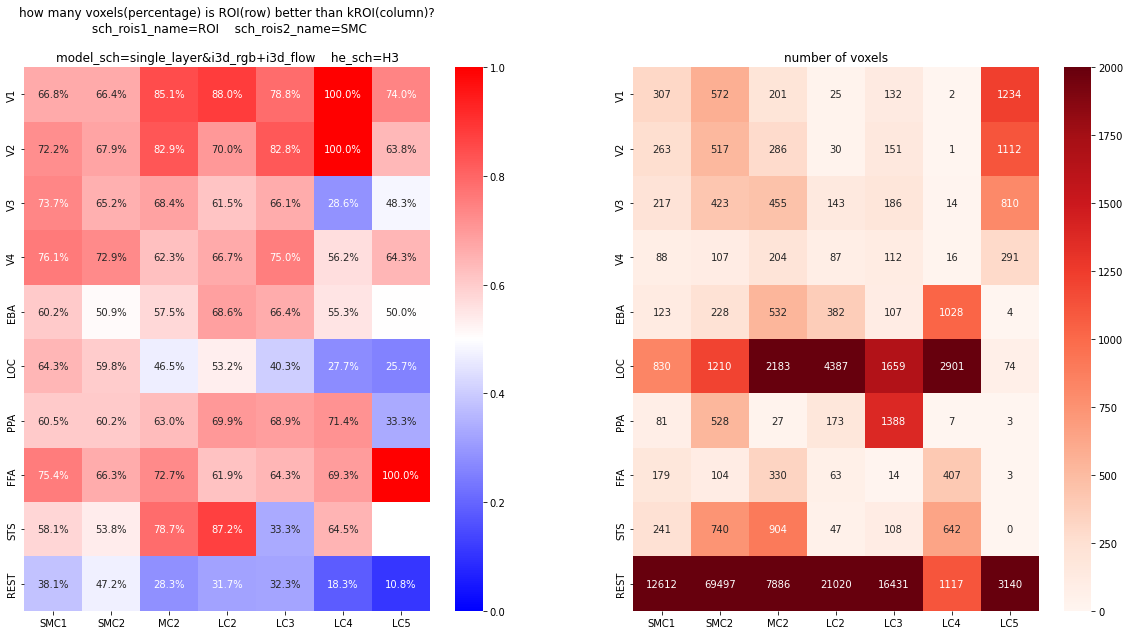

In [98]:
# for model_sch, he_sch in ensemble_configs:
model_sch = 'single_layer&i3d_rgb+i3d_flow'
he_sch = 'H3'
sch_rois2_name = 'SMC'
# for sch_rois2_name in sch_rois2_names:
df = my_query_df(cross_roi_df, equal_dict={'model_sch': model_sch, 'he_sch':he_sch, 'sch_rois2_name':sch_rois2_name})
# if len(df) == 0: continue
d1_name = df['roi1_name'].unique()
d2_name = df['roi2_name'].unique()

nrows = 1
ncols = 2
size = 10
fig, axs = plt.subplots(nrows, ncols, figsize=(size*ncols, size*nrows))

ax = axs[0]
better_percent_1 = df['voxel_swap_num_better_1'] / (df['voxel_swap_num_better_1'] + df['voxel_swap_num_better_2'])
tab_data1 = better_percent_1.values.reshape(len(d1_name), len(d2_name))
sns.heatmap(tab_data1, yticklabels=d1_name, xticklabels=d2_name, annot=True, fmt='.1%', cmap='bwr', ax=ax, vmin=0, vmax=1)
ax.set_title(f'how many voxels(percentage) is ROI(row) better than kROI(column)?\n '
          f'sch_rois1_name={sch_rois1_name}    sch_rois2_name={sch_rois2_name}\n '
          f'\nmodel_sch={model_sch}    he_sch={he_sch}')

ax = axs[1]
tab_data2 = df['num_intersect_voxels'].values.reshape(len(d1_name), len(d2_name))
sns.heatmap(tab_data2, yticklabels=d1_name, xticklabels=d2_name, annot=True, fmt='d', cmap='Reds', ax=ax, vmax=2000)
ax.set_title('number of voxels')
plt.show()

In [105]:
# all config

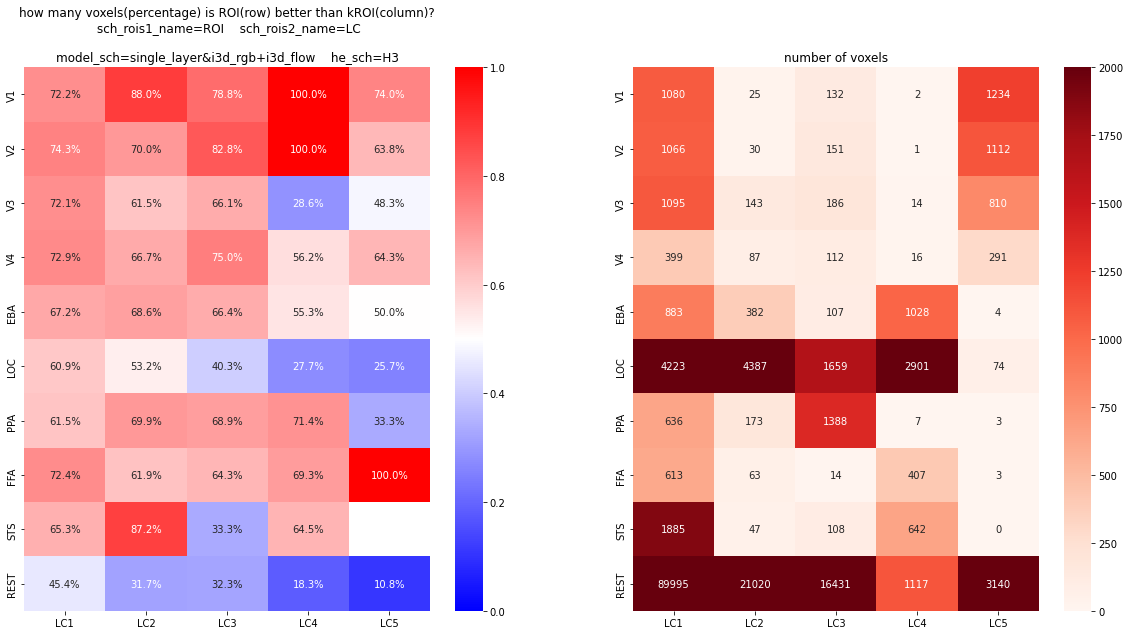

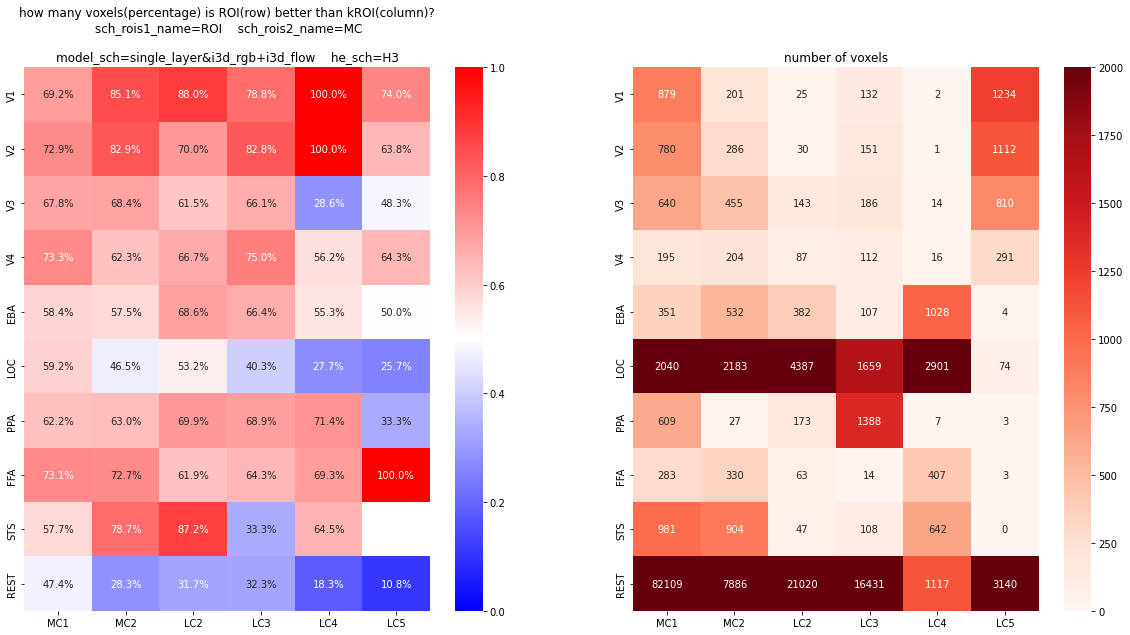

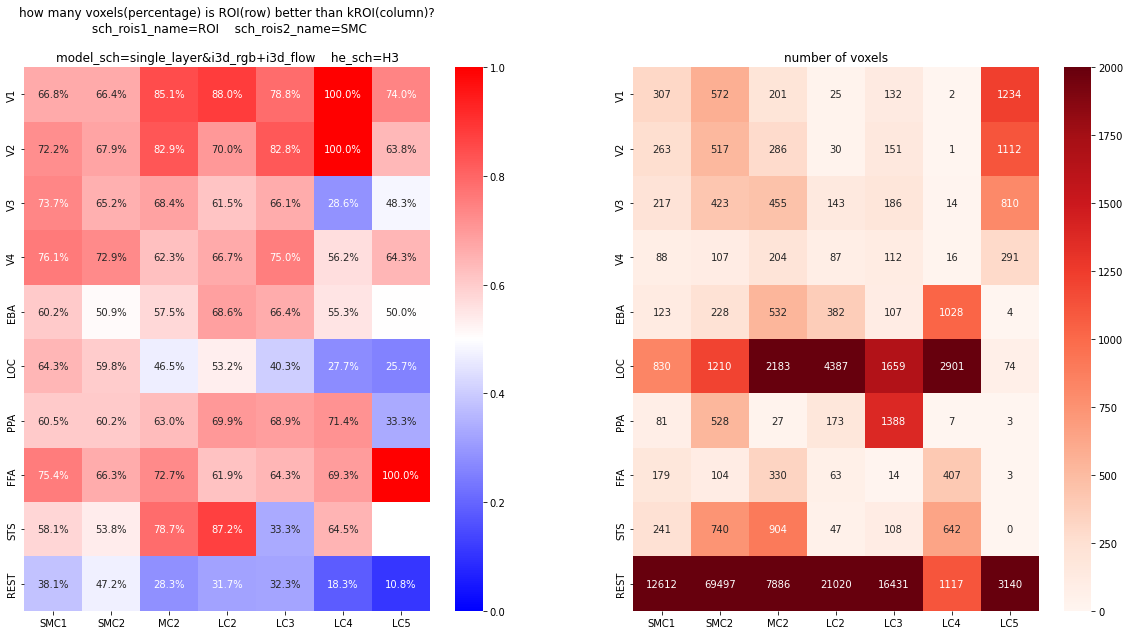

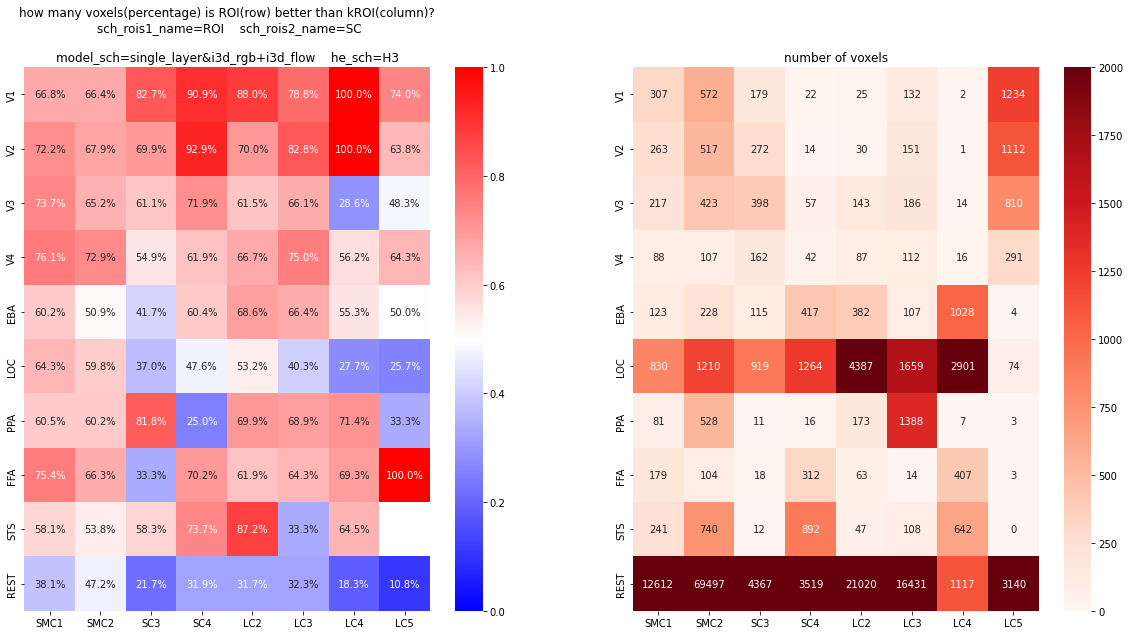

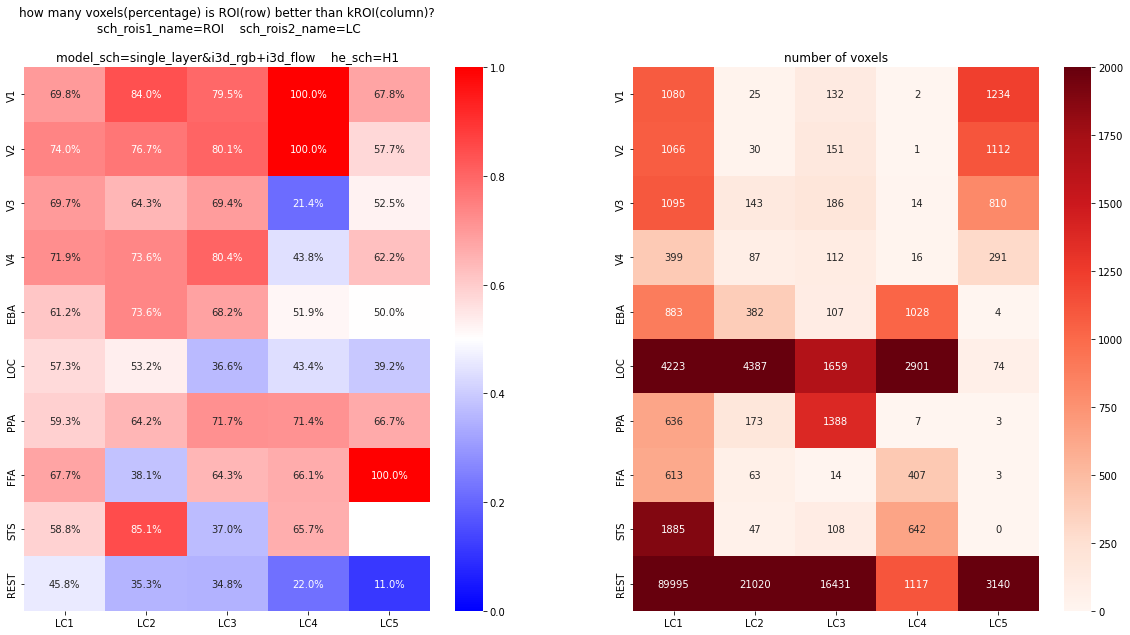

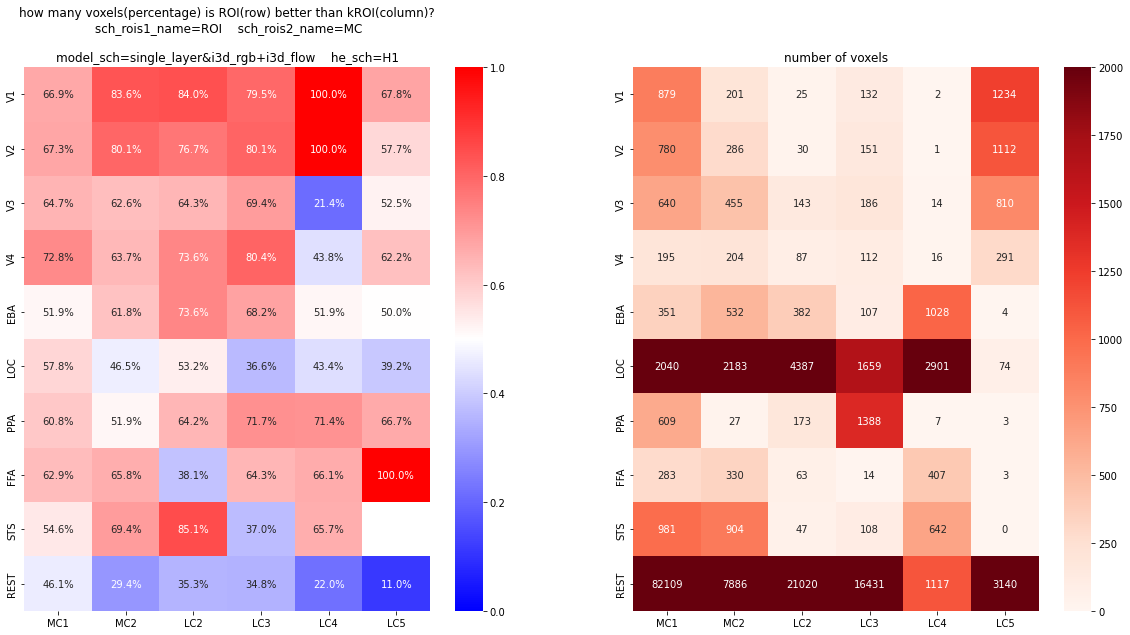

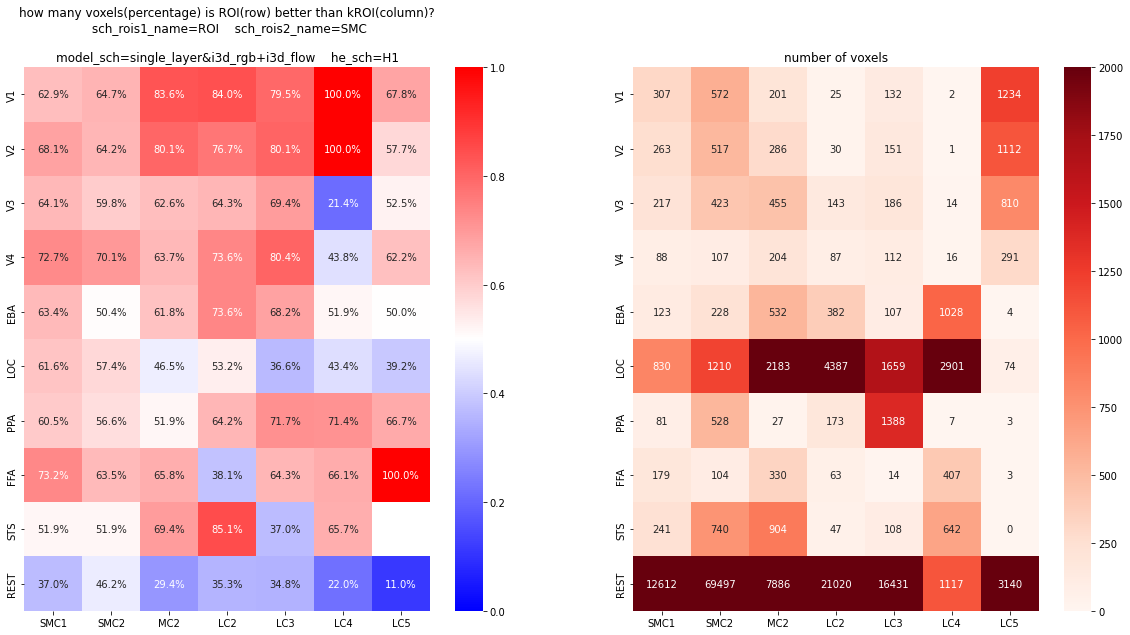

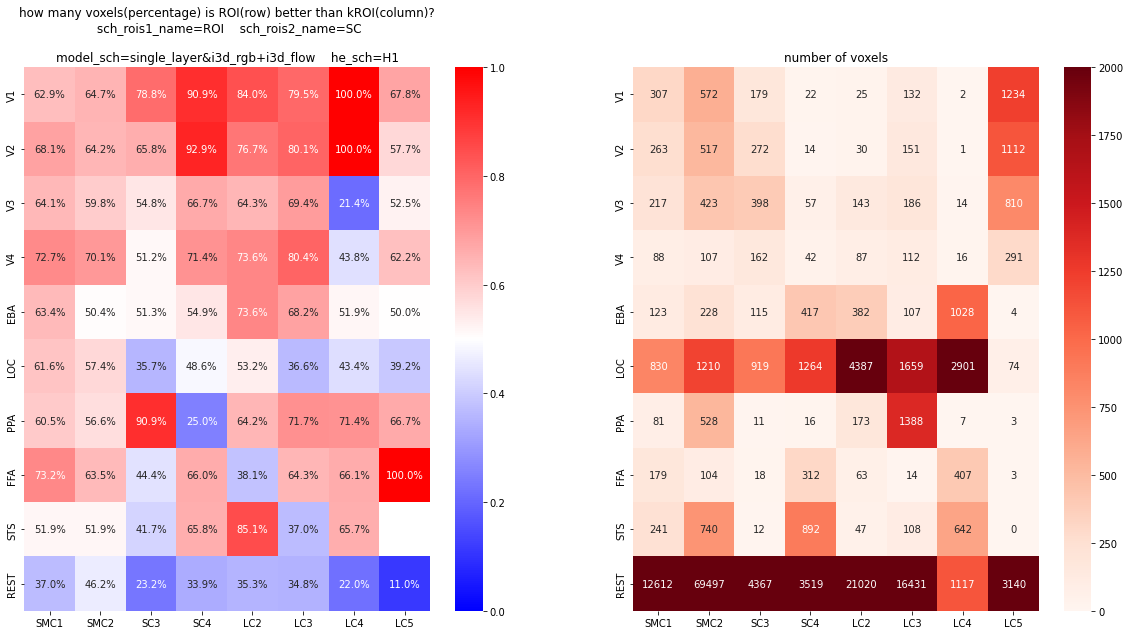

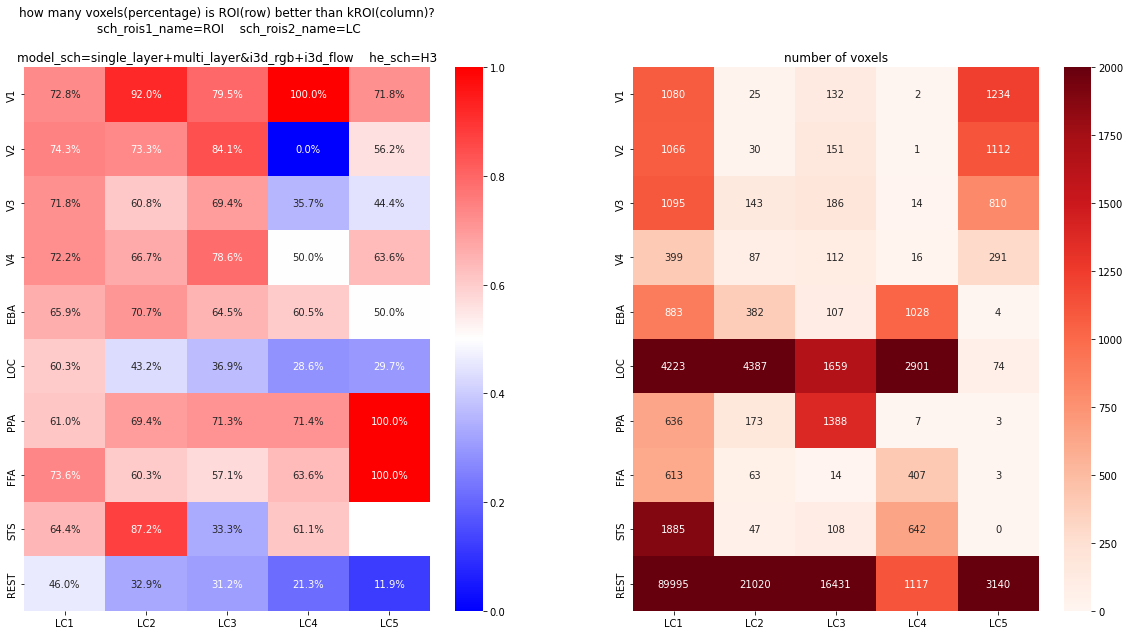

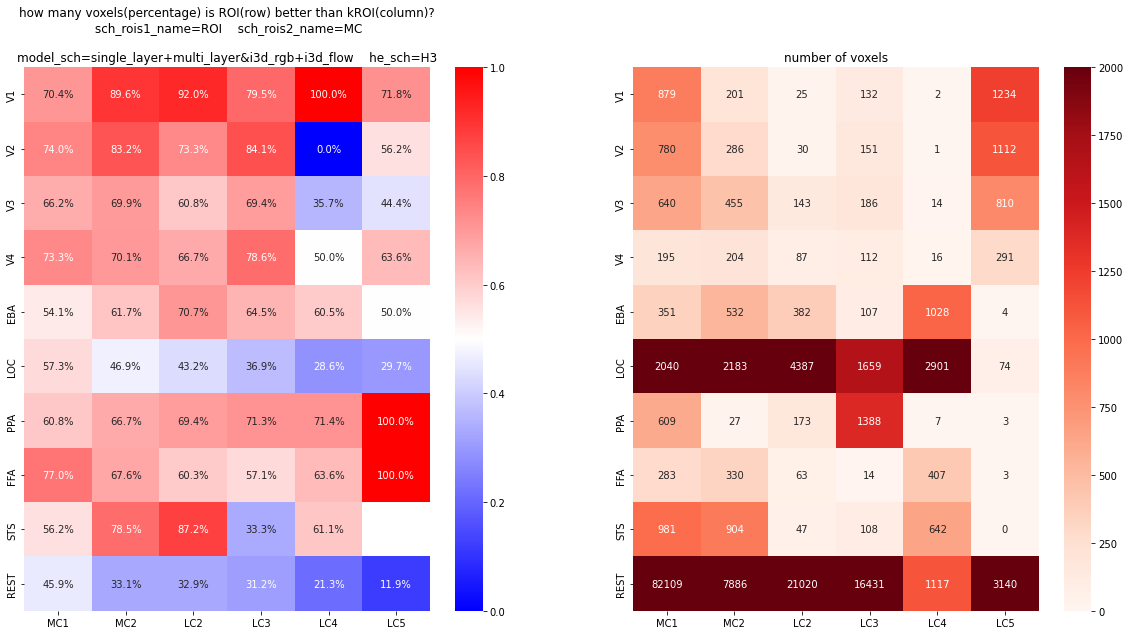

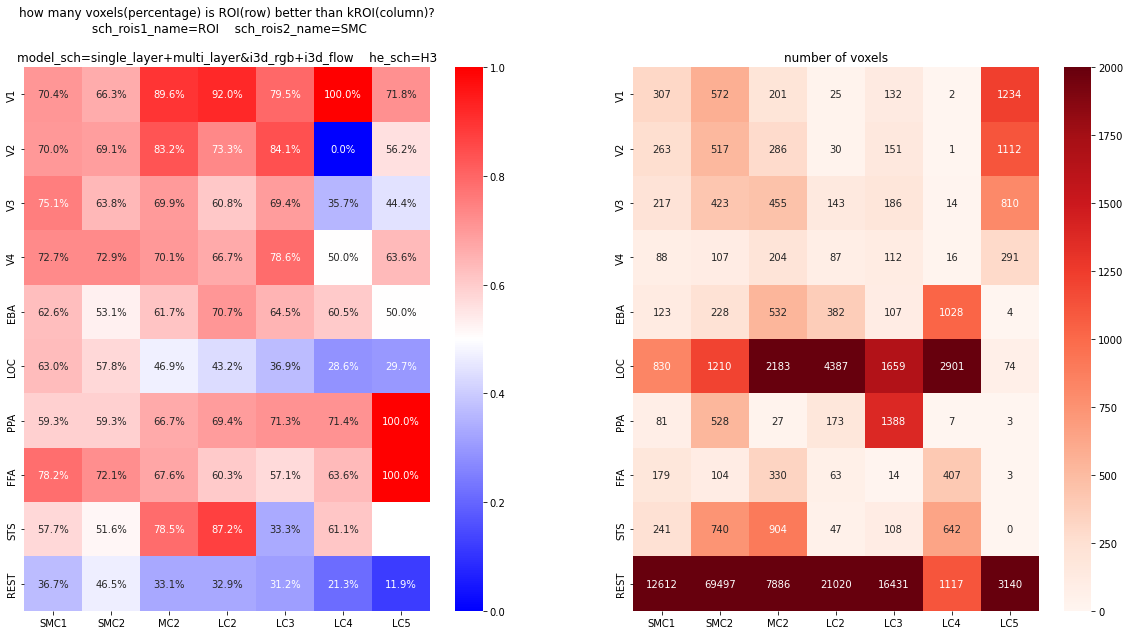

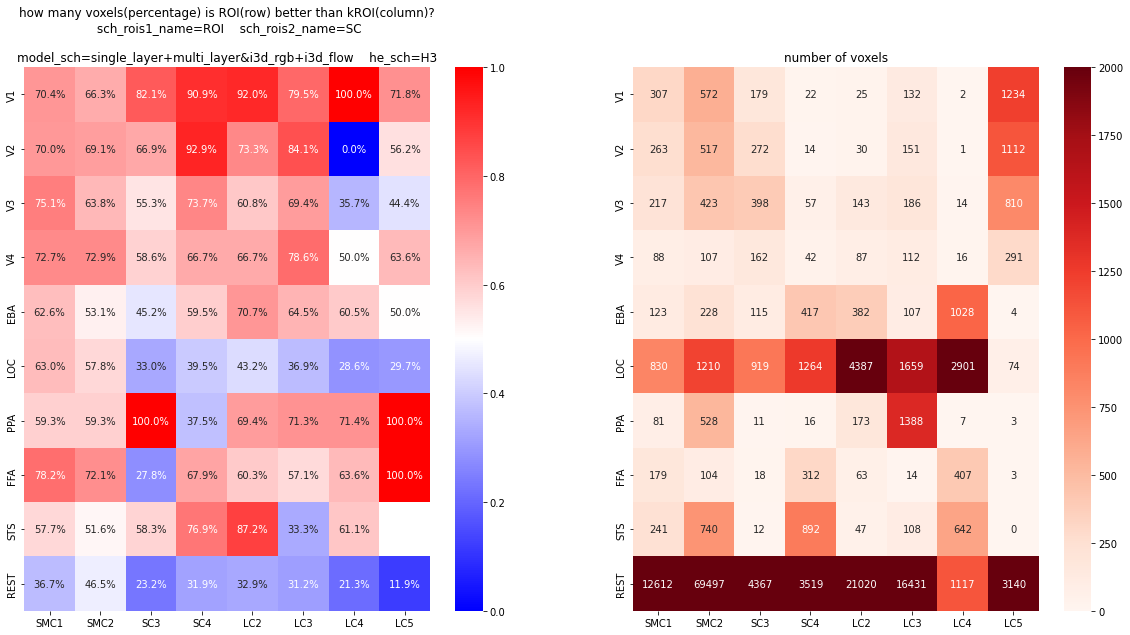

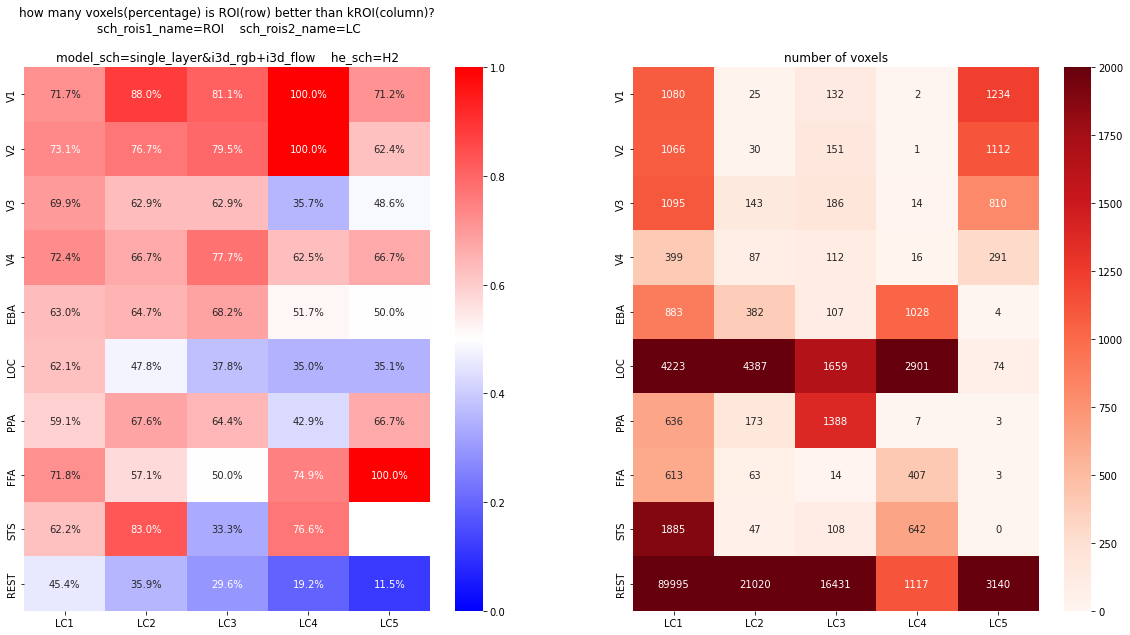

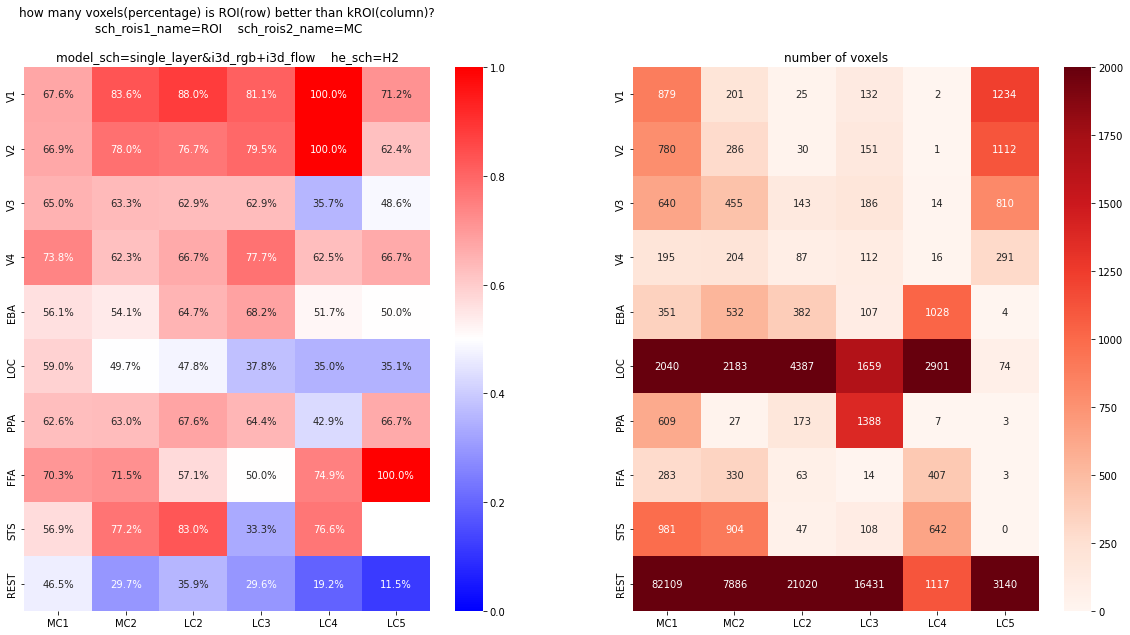

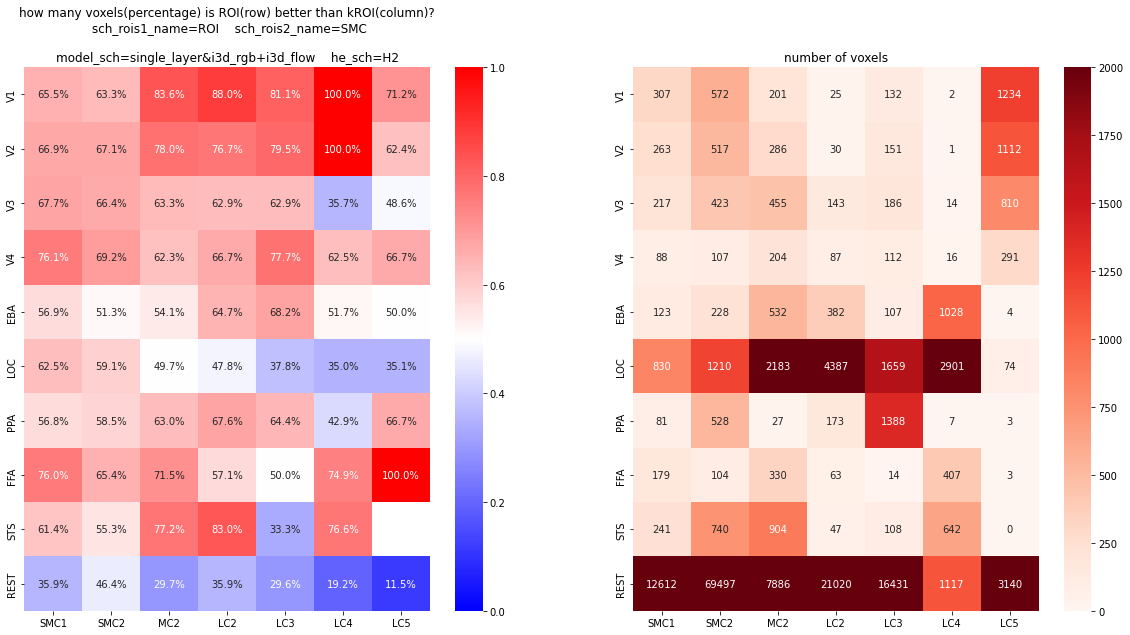

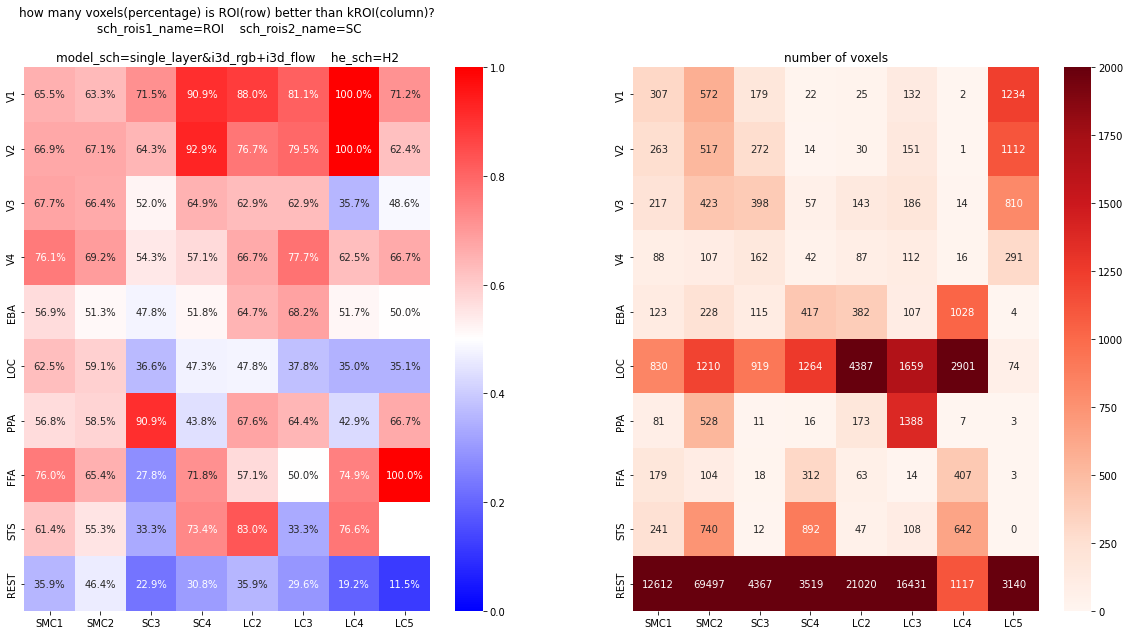

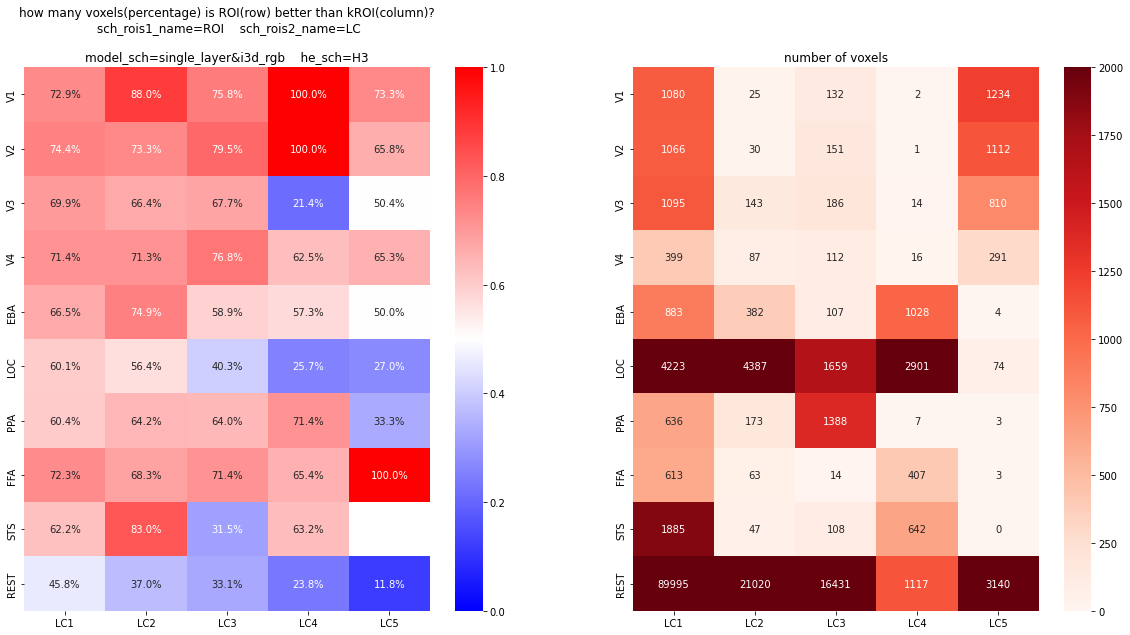

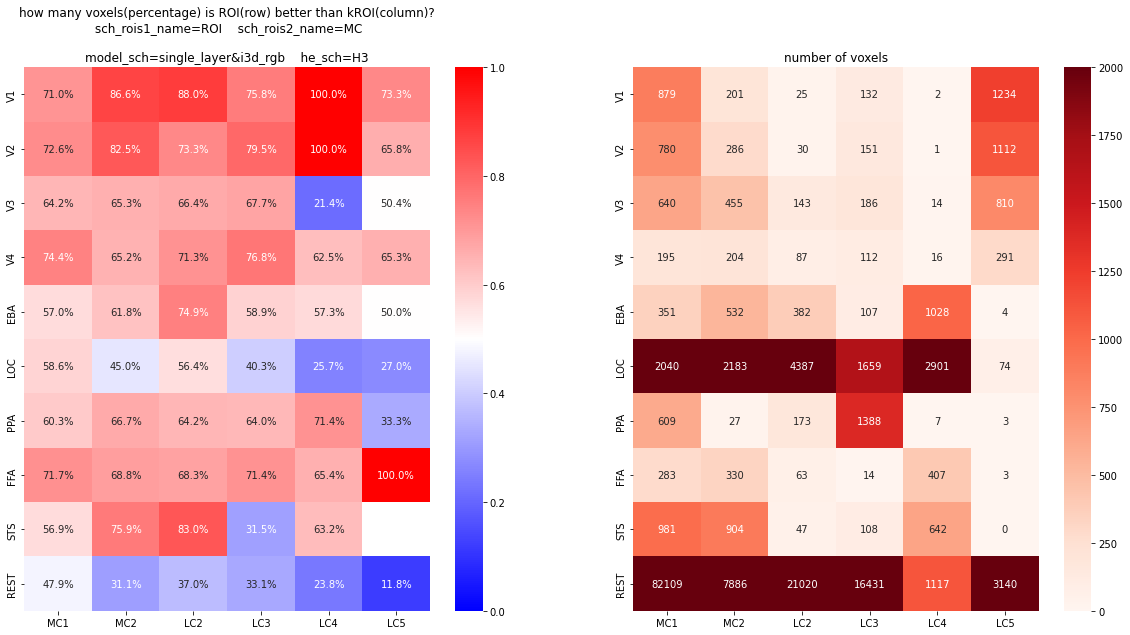

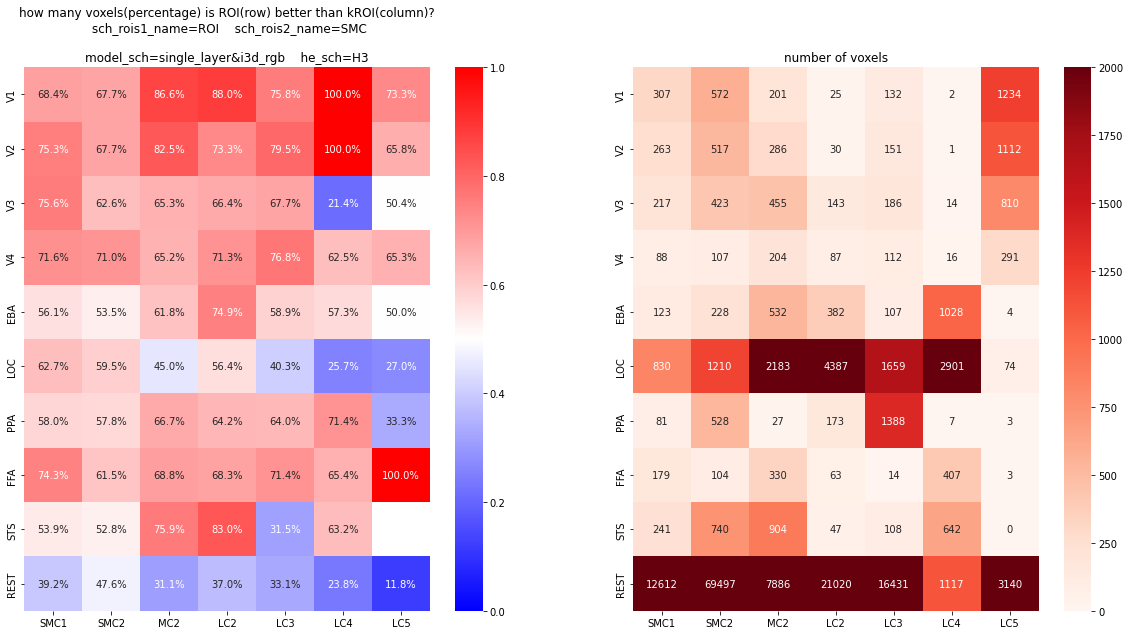

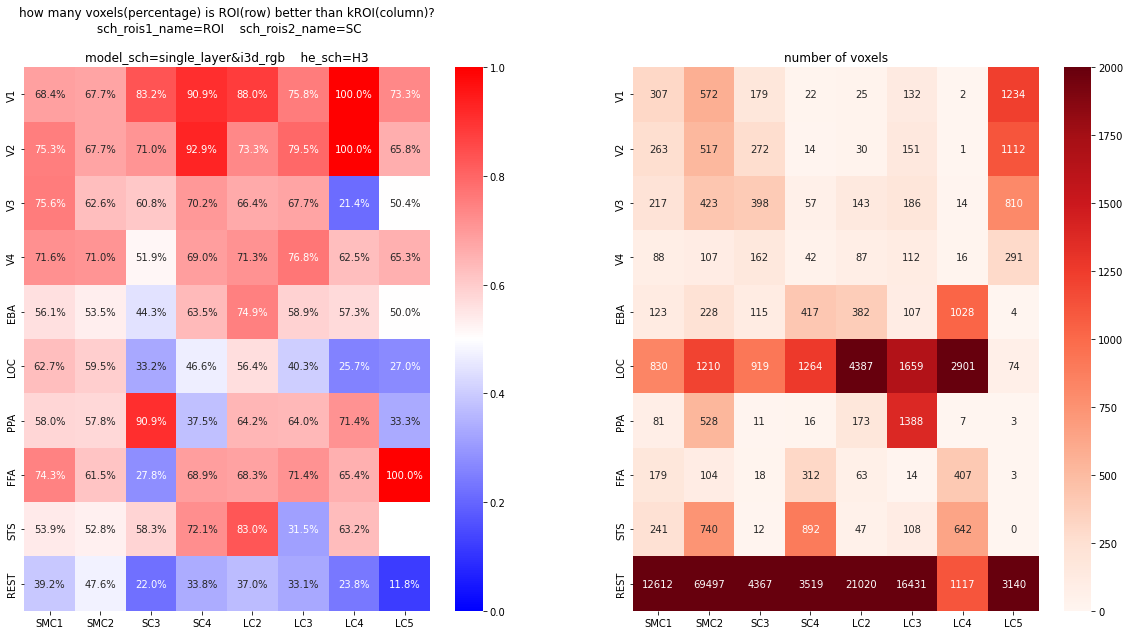

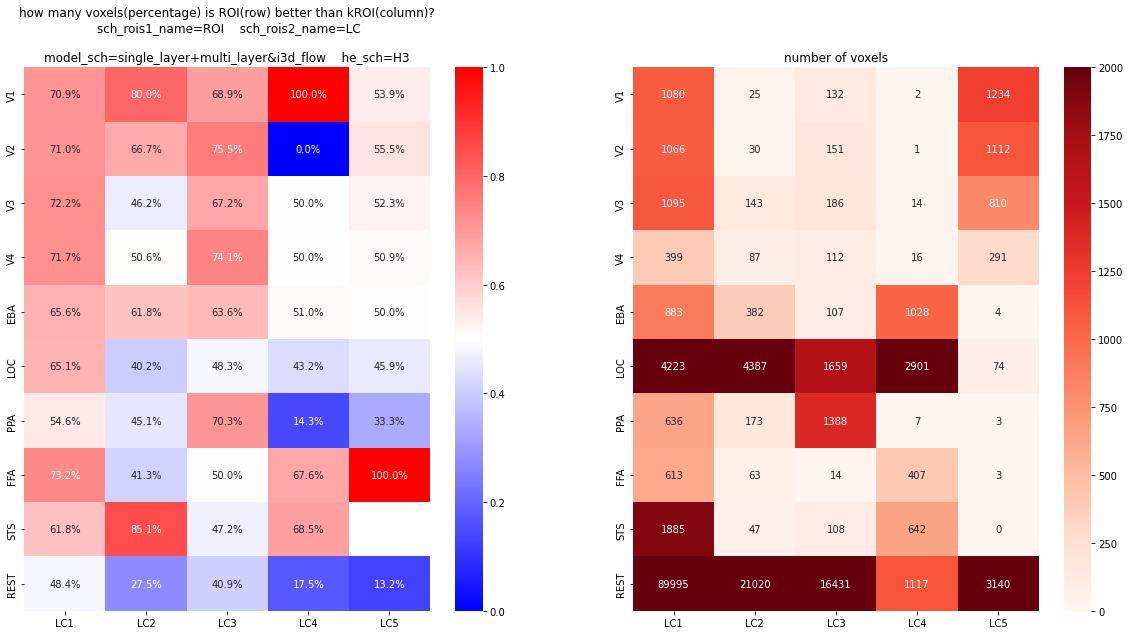

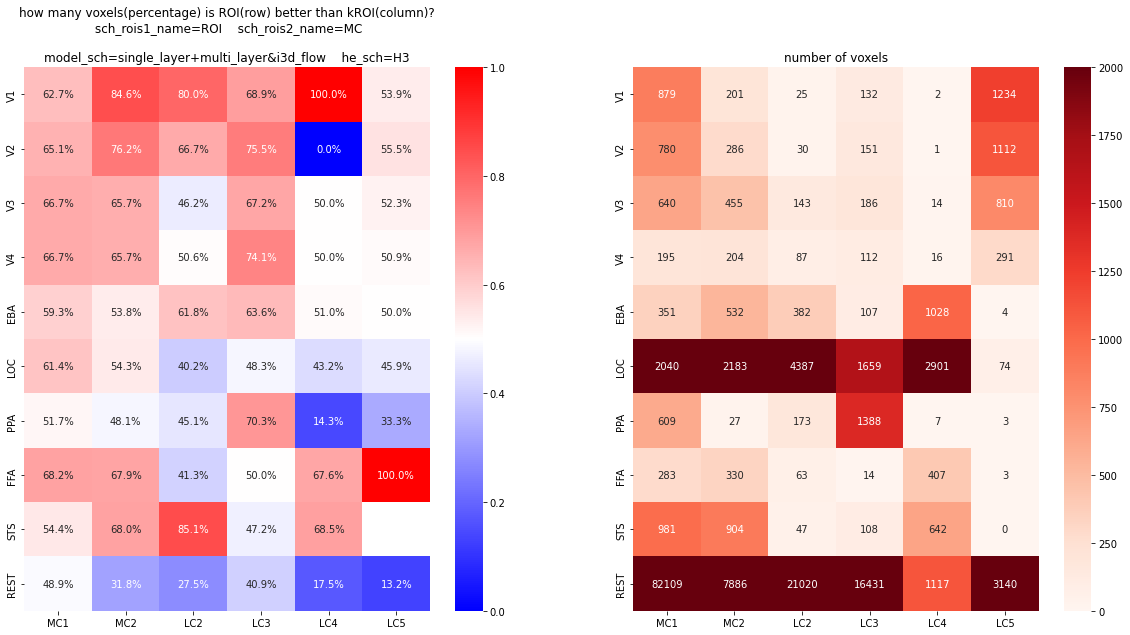

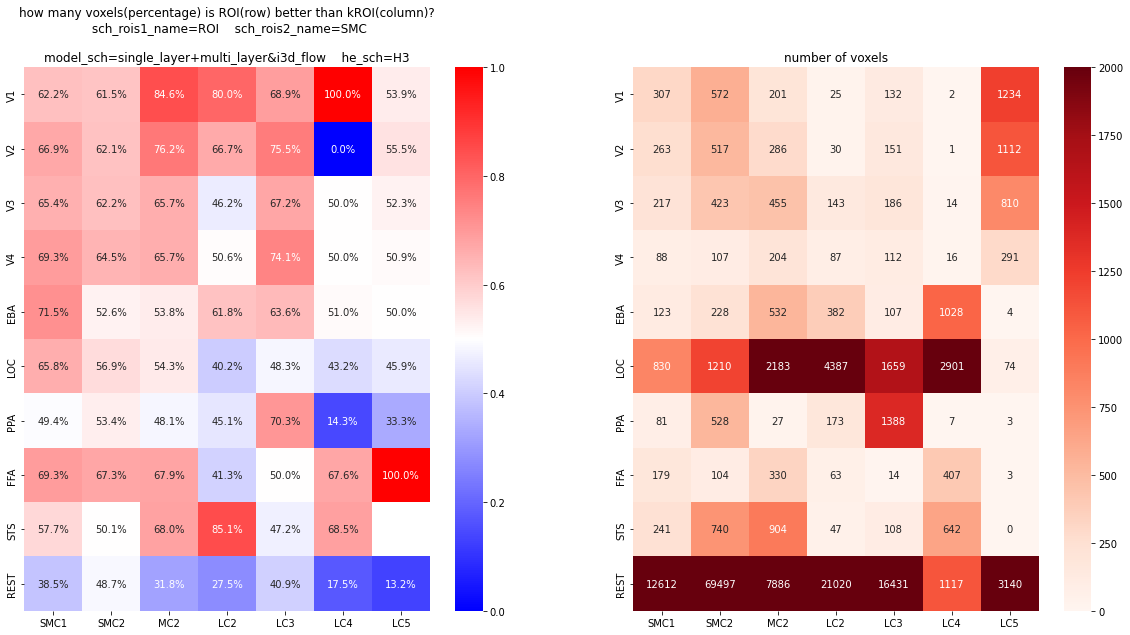

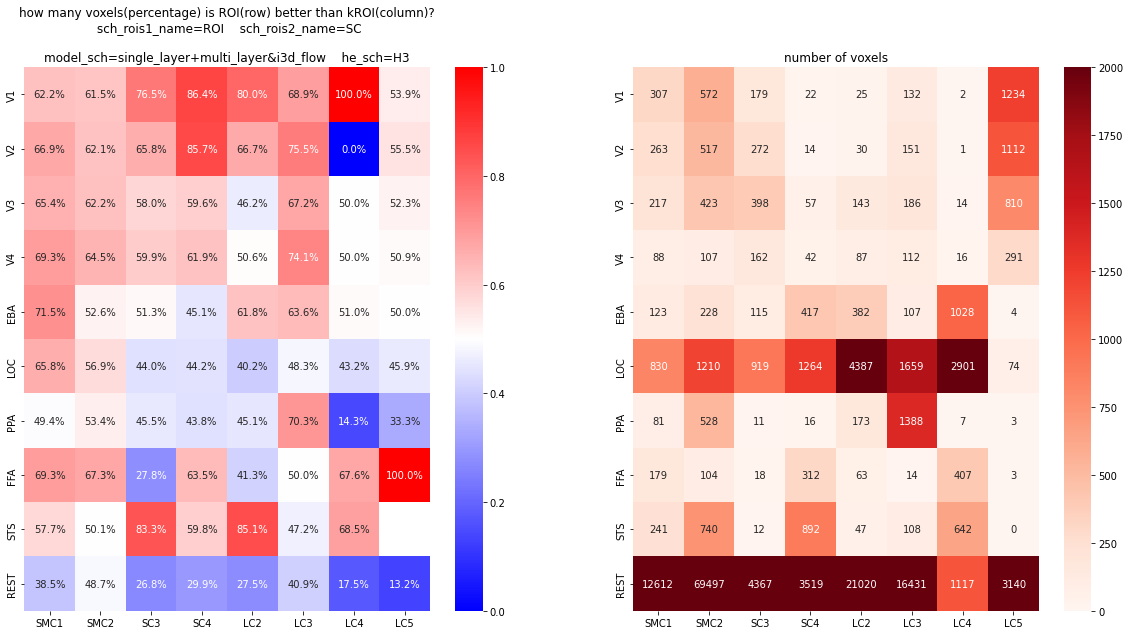

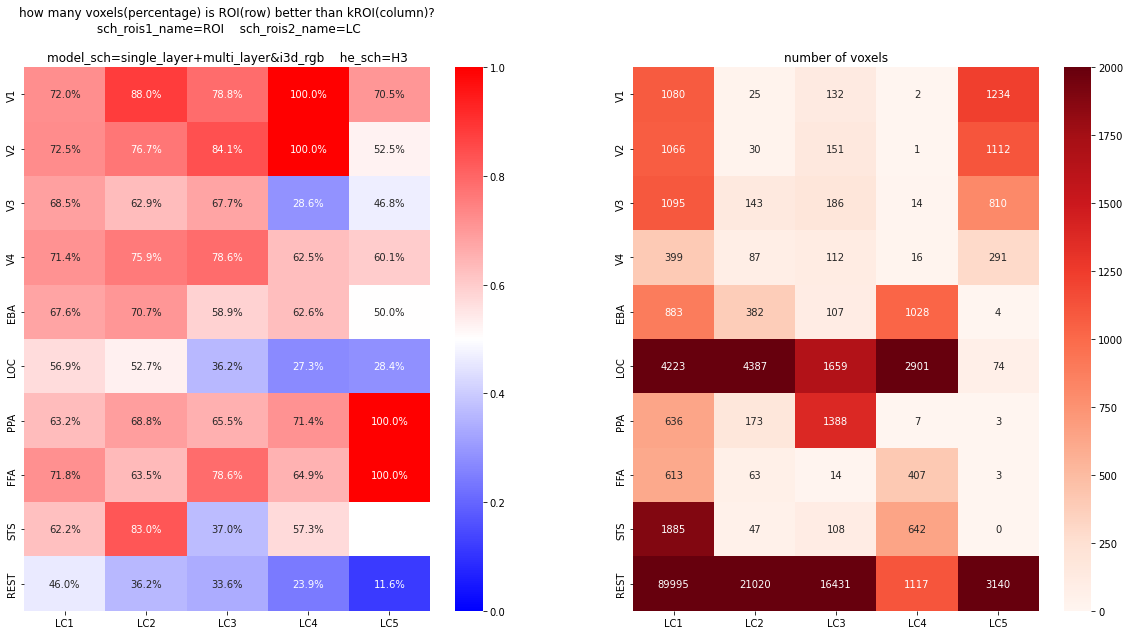

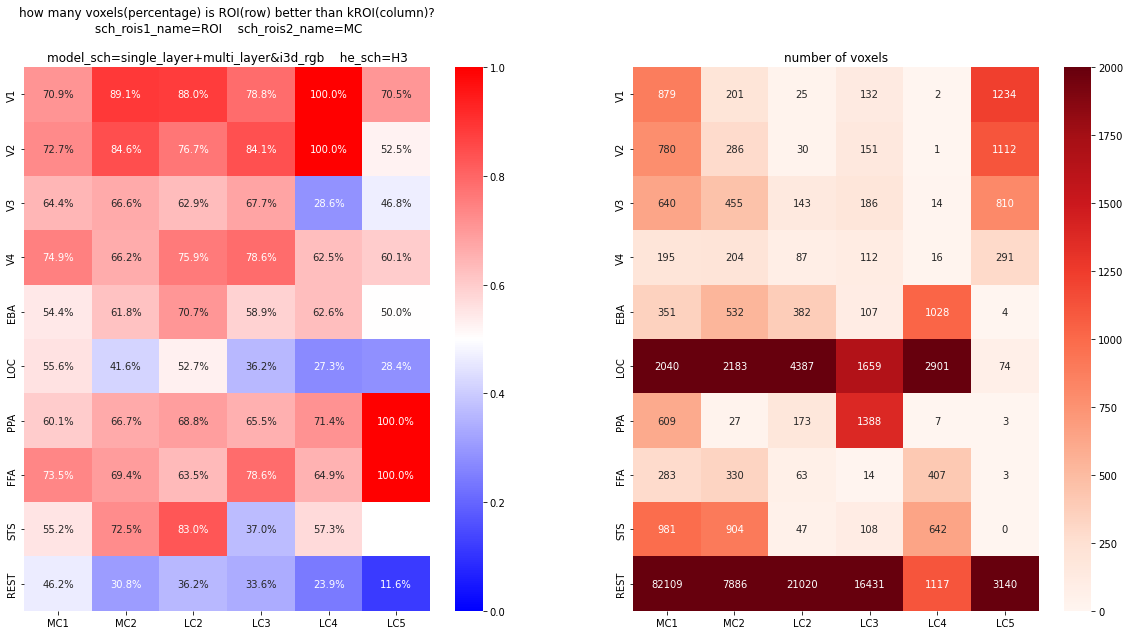

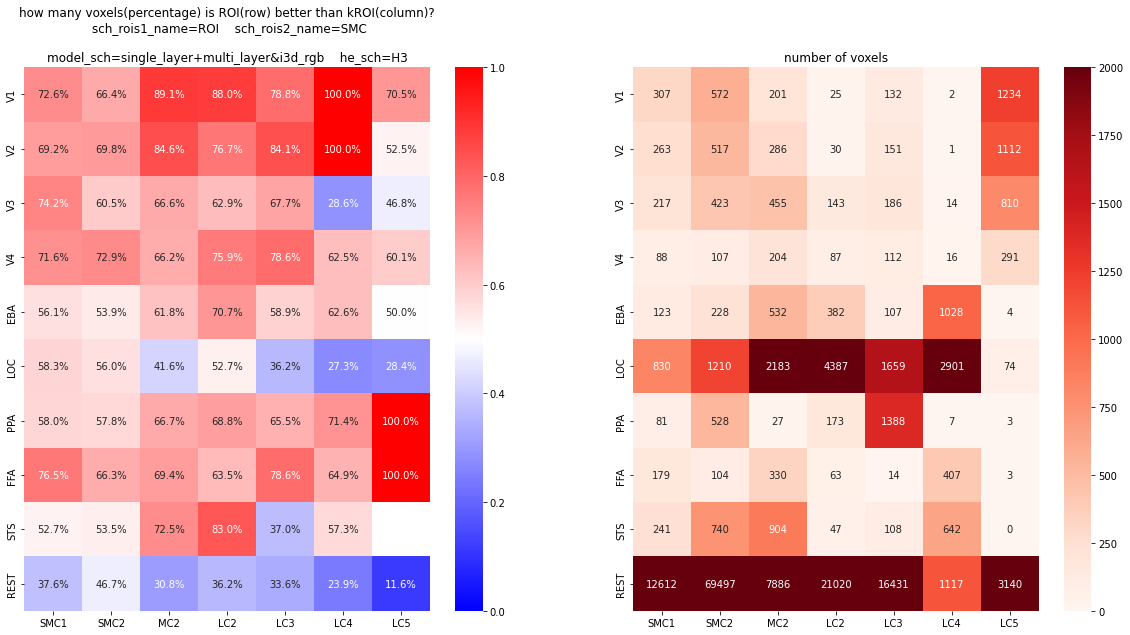

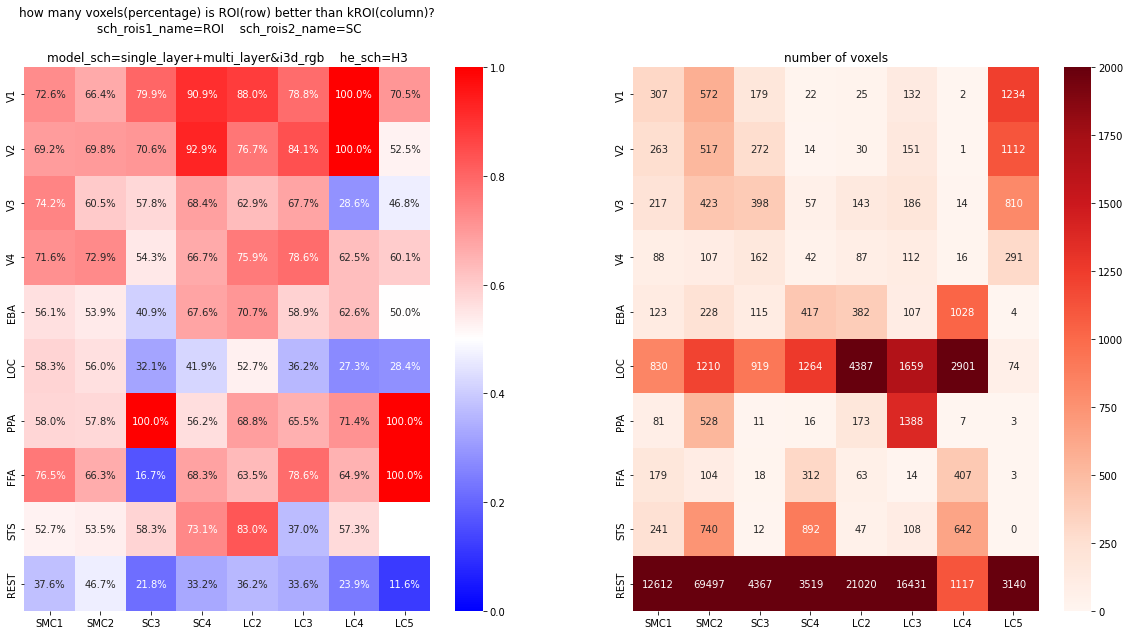

In [99]:
for model_sch, he_sch in ensemble_configs:
    # model_sch = 'single_layer&i3d_rgb+i3d_flow'
    # he_sch = 'H3'
    # sch_rois2_name = 'SMC'
    for sch_rois2_name in sch_rois2_names:
        df = my_query_df(cross_roi_df, equal_dict={'model_sch': model_sch, 'he_sch':he_sch, 'sch_rois2_name':sch_rois2_name})
        if len(df) == 0: continue
        d1_name = df['roi1_name'].unique()
        d2_name = df['roi2_name'].unique()

        nrows = 1
        ncols = 2
        size = 10
        fig, axs = plt.subplots(nrows, ncols, figsize=(size*ncols, size*nrows))

        ax = axs[0]
        better_percent_1 = df['voxel_swap_num_better_1'] / (df['voxel_swap_num_better_1'] + df['voxel_swap_num_better_2'])
        tab_data1 = better_percent_1.values.reshape(len(d1_name), len(d2_name))
        sns.heatmap(tab_data1, yticklabels=d1_name, xticklabels=d2_name, annot=True, fmt='.1%', cmap='bwr', ax=ax, vmin=0, vmax=1)
        ax.set_title(f'how many voxels(percentage) is ROI(row) better than kROI(column)?\n '
                  f'sch_rois1_name={sch_rois1_name}    sch_rois2_name={sch_rois2_name}\n '
                  f'\nmodel_sch={model_sch}    he_sch={he_sch}')

        ax = axs[1]
        tab_data2 = df['num_intersect_voxels'].values.reshape(len(d1_name), len(d2_name))
        sns.heatmap(tab_data2, yticklabels=d1_name, xticklabels=d2_name, annot=True, fmt='d', cmap='Reds', ax=ax, vmax=2000)
        ax.set_title('number of voxels')
        plt.show()